<a href="https://colab.research.google.com/github/Mwangi-dan/Gatric_cancer_classification-Model/blob/main/Daniel_Ndungu_Summative_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing of libraries

In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import os

Importing data

In [42]:
base_dir = ('/content/drive/MyDrive/kvasir-dataset/Model_data')

# Subset of Images
Since Keras is a very large dataset, I would want to use only a small portion of the dataset to train the model(s)

In [43]:
data_fraction = 0.2

In [143]:
# Data Generator for Kvasir Dataset
datagen = ImageDataGenerator(rescale=1./255)

### Data augmentation
Images in the dataset have been augmented to look as below just to enhance the results a bit. However, the quality of image data on Kvasir dataset is good enough that it;s not so necessary to augment it further

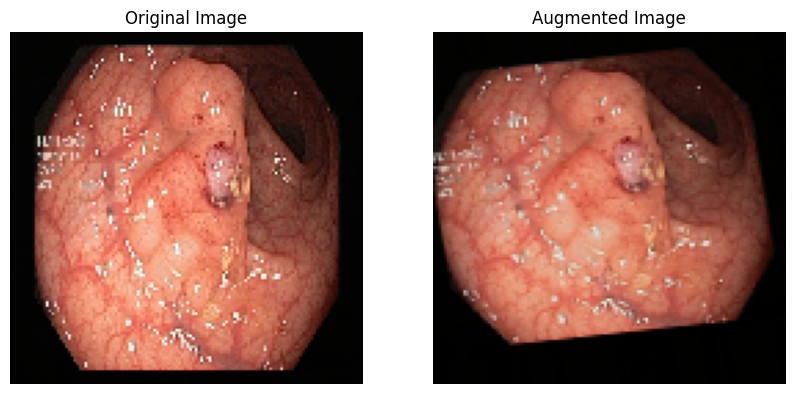

In [147]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Define the ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=15,  # Small rotation angle to simulate slight misalignments
    width_shift_range=0.1,  # Small horizontal shift
    height_shift_range=0.1,  # Small vertical shift
    zoom_range=0.2,  # Simulate various distances
    horizontal_flip=True,  # Safe for many medical images
    fill_mode='nearest',  # To avoid empty pixels after shifts or rotations
    brightness_range=[0.8, 1.2],  # Adjust brightness slightly to simulate different lighting conditions
    shear_range=0.1,
)

# Load a sample image from your dataset
img_path = base_dir + '/training_dataset/train/0a1a515a-b974-4d1d-9735-9bc248e96ba4.jpg'
img = load_img(img_path, target_size=(128, 128))  # Resize image to match the input size
img_array = img_to_array(img)  # Convert the image to a numpy array
img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match the format (batch_size, height, width, channels)

# Create an iterator to apply augmentations
augmented_img_iterator = datagen.flow(img_array, batch_size=1)

# Generate one augmented image
augmented_img = augmented_img_iterator.__next__()[0].astype('uint8') # Convert to uint8 for display

# Plot the original and augmented images side by side
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# Augmented Image
plt.subplot(1, 2, 2)
plt.imshow(augmented_img)
plt.title('Augmented Image')
plt.axis('off')

# Show the images
plt.show()


# Vanilla CNN Model

Loading only a fraction of the training data

In [108]:
# Load only a fraction of the training data
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

Found 132 images belonging to 3 classes.


## Validation generators
Loading a portion of the validation data

In [109]:
validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=True,
    seed=42
)

Found 32 images belonging to 3 classes.


## Limiting the bumber of batches in each generator

In [48]:
train_generator.samples = int(train_generator.samples * data_fraction)
validation_generator.samples = int(validation_generator.samples * data_fraction)

## Early stopping and model checkpoint callbacks

In [49]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)


# Model Implementation

In [50]:
model = Sequential([
    # Convolutional layers with pooling
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    # Dense layers with dropout for regularization
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),

    # Output layer with softmax or sigmoid, depending on the problem
    Dense(1, activation='sigmoid')  # For binary classification
])

Compiling the model

In [51]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [52]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,312,961 (12.64 MB)

 Trainable params: 3,312,961 (12.64 MB)

 Non-trainable params: 0 (0.00 B)

## Training model

In [53]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.4265 - loss: 18.9506 - val_accuracy: 0.5000 - val_loss: 24.2238
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 608ms/step - accuracy: 0.5104 - loss: 52.8238 - val_accuracy: 0.5000 - val_loss: 5.0940
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.3392 - loss: 22.8927 - val_accuracy: 0.8000 - val_loss: 0.5386
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 664ms/step - accuracy: 0.5735 - loss: 3.7555 - val_accuracy: 0.9000 - val_loss: 0.3610
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 425ms/step - accuracy: 0.6853 - loss: 1.8525 - val_accuracy: 0.7000 - val_loss: 0.9147
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 428ms/step - accuracy: 0.7692 - loss: 1.7449 - val_accuracy: 0.6000 - val_loss: 1.7301
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7516 - loss: 1.2555 - val_accuracy: 0.8000 - val_loss: 0.3827


# Model Evaluation

In [55]:
model.load_weights('best_model.keras')

In [56]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9000 - loss: 0.3610
Validation Accuracy: 0.90


In [61]:
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.9000 - loss: 0.3610
Test Loss: 0.36099594831466675
Test Accuracy: 0.8999999761581421


# Visualizations

In [57]:
import cv2
import tensorflow.keras.backend as K

## Validation & Loss Accuracy

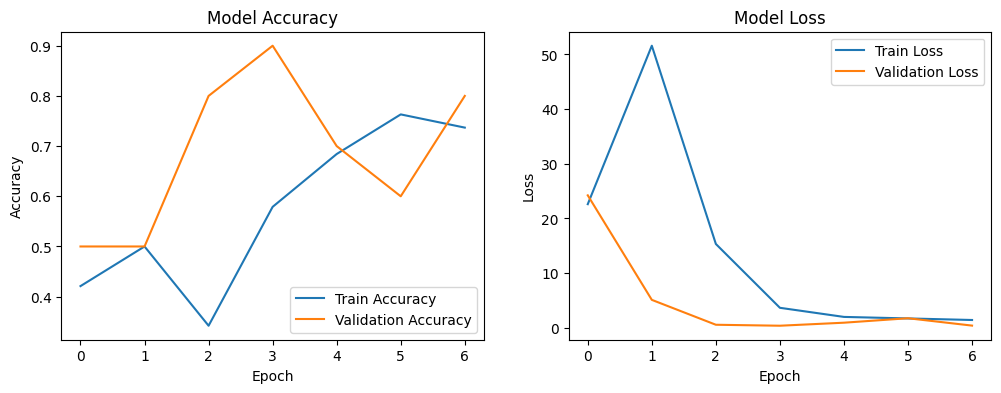

In [65]:
# Plot accuracy and loss over epochs
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()


plot_training_history(history)

## Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


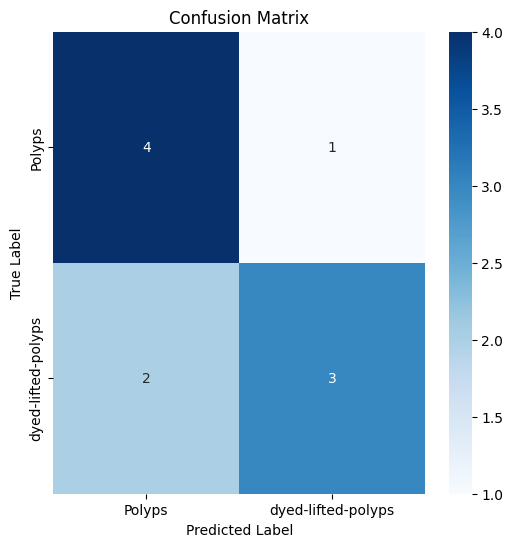

                    precision    recall  f1-score   support

            Polyps       0.67      0.80      0.73         5
dyed-lifted-polyps       0.75      0.60      0.67         5

          accuracy                           0.70        10
         macro avg       0.71      0.70      0.70        10
      weighted avg       0.71      0.70      0.70        10



In [70]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions and convert probabilities to binary classes (0 or 1)
predictions = model.predict(validation_generator)
predicted_classes = (predictions > 0.5).astype("int32").flatten()
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification report for detailed metrics
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


## Saving Model - CNN model

In [73]:
model.save("cnn_model.keras")

### Confirming integrity of model

In [76]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model("cnn_model.keras")

test_loss, test_accuracy = loaded_model.evaluate(validation_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step - accuracy: 0.9000 - loss: 0.3610
Test Loss: 0.36099591851234436
Test Accuracy: 0.8999999761581421


# CNN Model with L1 Regularization

In [102]:
from tensorflow.keras.regularizers import l1

In [126]:
# Image data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)  # Only normalization for validation

# Load the training and validation data
train_generator = train_datagen.flow_from_directory(
    base_dir + '/training_dataset',  # Path to your training dataset
    target_size=(128, 128),  # Resize images to 128x128
    batch_size=32,
    class_mode='binary'  # Binary classification (cancer vs non-cancer)
)

validation_generator = validation_datagen.flow_from_directory(
    base_dir + '/training_dataset',  # Path to your validation dataset
    target_size=(128, 128),  # Resize validation images to match input size
    batch_size=32,
    class_mode='binary'
)


Found 110 images belonging to 2 classes.
Found 110 images belonging to 2 classes.


In [127]:
model_l1 = Sequential()

# Convolutional layers with L1 regularization
model_l1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer=l1(0.01)))
model_l1.add(MaxPooling2D(pool_size=(2, 2)))

model_l1.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l1(0.01)))
model_l1.add(MaxPooling2D(pool_size=(2, 2)))


model_l1.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l1(0.01)))
model_l1.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output to feed it into the dense layers
model_l1.add(Flatten())

# Fully Connected Layer with L1 regularization
model_l1.add(Dense(128, activation='relu', kernel_regularizer=l1(0.01)))
model_l1.add(Dropout(0.5))


model_l1.add(Dense(1, activation='sigmoid'))

# Compile the model
model_l1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model_l1.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [128]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("cnn_model_l1_regularization.keras", save_best_only=True)

In [129]:
# Model Training
history_l1 = model_l1.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4781 - loss: 254.2369 - val_accuracy: 0.5727 - val_loss: 167.9331
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5887 - loss: 145.5822 - val_accuracy: 0.5727 - val_loss: 94.5740
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5557 - loss: 82.1139 - val_accuracy: 0.5727 - val_loss: 56.7688
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5825 - loss: 54.3854 - val_accuracy: 0.5727 - val_loss: 52.6538
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5901 - loss: 51.9800 - val_accuracy: 0.5727 - val_loss: 46.2261
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5812 - loss: 43.5628 - val_accuracy: 0.5727 - val_loss: 32.7289
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.5268 - loss: 30.5975 - val_accuracy: 0.5727 - val_loss: 25.5724
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.5900 - loss: 25.0325 - val_accuracy: 0.5727 - val_loss: 22.2209
Epoc

## L1 Model Evalution

In [130]:
test_loss, test_accuracy = model_l1.evaluate(validation_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 416ms/step - accuracy: 0.5655 - loss: 14.4218
Test Loss: 14.421038627624512
Test Accuracy: 0.5727272629737854


## Visualizations

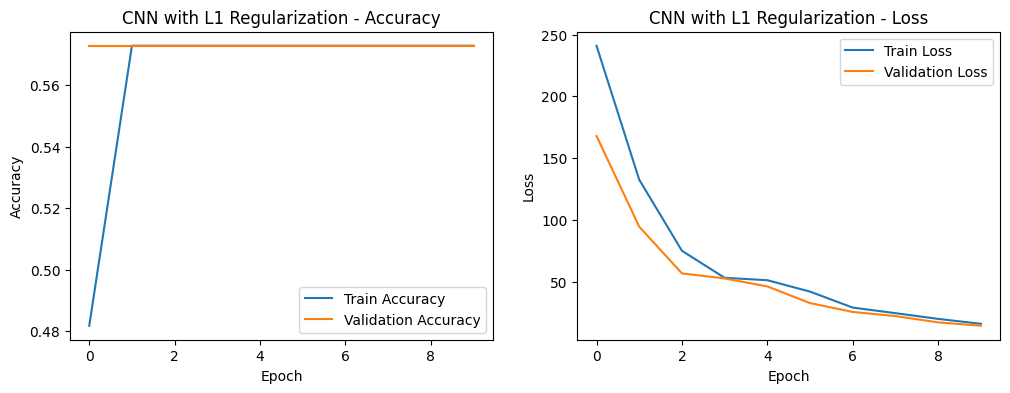

In [131]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('CNN with L1 Regularization - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('CNN with L1 Regularization - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history_l1)


### Saving L1 CNN Model

In [132]:
model_l1.save("cnn_model_l1_regularization.h5")

# CNN Model with L2 Regularization

In [133]:
from tensorflow.keras.regularizers import l2

In [134]:
model_l2 = Sequential()

# Convolutional layers with L2 Regularization
model_l2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer=l2(0.01)))
model_l2.add(MaxPooling2D(pool_size=(2, 2)))


model_l2.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_l2.add(MaxPooling2D(pool_size=(2, 2)))


model_l2.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_l2.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output to feed it into the dense layers
model_l2.add(Flatten())

# Fully Connected Layer with L2 regularization
model_l2.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model_l2.add(Dropout(0.5))  # Dropout to prevent overfitting

# Output Layer for Binary Classification (Cancerous or Non-Cancerous)
model_l2.add(Dense(1, activation='sigmoid'))

# Compile the model
model_l2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model_l2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [139]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("cnn_model_l1_regularization.keras", save_best_only=True)

# Train the model
history_l2 = model_l2.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5551 - loss: 1.0997 - val_accuracy: 0.5727 - val_loss: 1.0506
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5212 - loss: 1.0633 - val_accuracy: 0.5727 - val_loss: 1.0037
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5353 - loss: 1.0123 - val_accuracy: 0.5727 - val_loss: 0.9634
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.5482 - loss: 0.9664 - val_accuracy: 0.5727 - val_loss: 0.9325
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5827 - loss: 0.9220 - val_accuracy: 0.5727 - val_loss: 0.9057
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.6532 - loss: 0.8796 - val_accuracy: 0.5727 - val_loss: 0.8840
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5981 - loss: 0.8718 - val_accuracy: 0.5727 - val_loss: 0.8594
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5702 - loss: 0.8619 - val_accuracy: 0.5727 - val_loss: 0.8448
Epoch 9/10


### Evaluation of L2 model

In [140]:
test_loss, test_accuracy = model_l2.evaluate(validation_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 366ms/step - accuracy: 0.5874 - loss: 0.8199
Test Loss: 0.8216337561607361
Test Accuracy: 0.5727272629737854


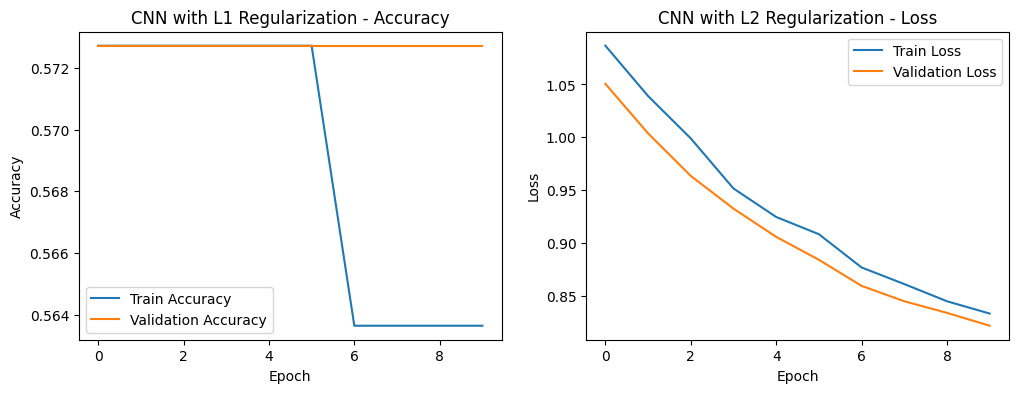

In [141]:
# Visualization
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('CNN with L1 Regularization - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('CNN with L2 Regularization - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history_l2)


In [142]:
# Saving L2 Model
model_l2.save("cnn_model_l2_regularization.h5")

# VGG16 Model
Transfer Learning approach




In [77]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

In [78]:
# Loading the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [79]:
# Freeze the base model's layers to retain pre-trained features
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)

## Model

In [80]:
model_vgg16 = Model(inputs=base_model.input, outputs=output_layer)

In [81]:
# Compile the model
model_vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [82]:
model_vgg16.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,771,713 (60.16 MB)

 Trainable params: 1,057,025 (4.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Training

In [84]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("vgg16_transfer_learning.keras", save_best_only=True)

In [85]:
# Training the model
history_vgg16 = model_vgg16.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 9s/step - accuracy: 0.5351 - loss: 8.6418 - val_accuracy: 0.7000 - val_loss: 1.5933
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.6469 - loss: 7.3720 - val_accuracy: 0.9000 - val_loss: 0.1557
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.6573 - loss: 6.6155 - val_accuracy: 0.9000 - val_loss: 0.5586
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 8s/step - accuracy: 0.8041 - loss: 6.1271 - val_accuracy: 0.9000 - val_loss: 1.1191
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.7029 - loss: 5.1964 - val_accuracy: 0.9000 - val_loss: 0.6655
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 9s/step - accuracy: 0.6988 - loss: 5.1561 - val_accuracy: 1.0000 - val_loss: 7.9823e-05
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.8427 - loss: 1.9072 - val_accuracy: 1.0000 - val_loss: 0.0475
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 8s/step - accuracy: 0.6930 - loss: 5.2727 - val_accuracy: 0.9000 - val_loss: 0.0762
Epoch

## Model Evaluation

In [90]:
test_loss, test_accuracy = model_vgg16.evaluate(validation_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 7.9823e-05
Test Loss: 7.982282841112465e-05
Test Accuracy: 1.00
